# Import des librairies

In [17]:
%%time
import time
init_time = time.time()

import os
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

import numpy as np
import pandas as pd
import sklearn
import pickle


from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec


import seaborn as sns

import string
import re

# Tensorflow
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

#Scikit-learn
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, precision_score, mean_squared_error, r2_score
from sklearn.calibration import CalibrationDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from xgboost import XGBClassifier

# Modèles de Boosting
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


print("Python version:", sys.version)
print("Version info.:", sys.version_info)
print("pandas version:", pd.__version__)
print("numpy version:", np.__version__)
print("skearn version:", sklearn.__version__)
print("re version:", re.__version__)
#print("nltk version:", nltk.__version__)
print("tensorflow version:", tf.__version__)
print("tensorflow_hub version:", hub.__version__)
print("tensorflow_text version:", text.__version__)

Python version: 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]
Version info.: sys.version_info(major=3, minor=11, micro=12, releaselevel='final', serial=0)
pandas version: 2.1.4
numpy version: 1.26.4
skearn version: 1.4.2
re version: 2.2.1
tensorflow version: 2.18.0
tensorflow_hub version: 0.16.1
tensorflow_text version: 2.18.1
CPU times: user 1.53 ms, sys: 0 ns, total: 1.53 ms
Wall time: 1.62 ms


# Chargement des données

In [2]:
path = "/content/drive/MyDrive/data/sentiments"
#path = "./data/sentiments"

In [3]:
%%time
tweets_df_count_vectorizer_1gram = np.load(os.path.join(path, "tweets_df_em_1gram.npy"), allow_pickle=True)
tweets_df_count_vectorizer_2gram = np.load(os.path.join(path, "tweets_df_em_2gram.npy"), allow_pickle=True)

tweets_df_tfidf_1gram = np.load(os.path.join(path, "tweets_df_tfidf_1gram.npy"), allow_pickle=True)

tweets_embeddings_bert = np.load(os.path.join(path, "embeddings_bert.npy"), allow_pickle=True)
tweets_embeddings_fasttext = np.load(os.path.join(path, "embeddings_fasttext.npy"), allow_pickle=True)
tweets_embeddings_word2vec = pickle.load(open(os.path.join(path, "embeddings_word2vec.pkl"), "rb"))

CPU times: user 3.79 s, sys: 5.85 s, total: 9.64 s
Wall time: 1min 21s


In [5]:
print(tweets_df_count_vectorizer_1gram.item().shape)
print(tweets_df_count_vectorizer_2gram.item().shape)
print(tweets_df_tfidf_1gram.item().shape)
print(pd.Series(tweets_embeddings_word2vec).shape)
print(tweets_embeddings_fasttext.shape)
print(tweets_embeddings_bert.shape)

(1593071, 695610)
(1593071, 695643)
(1593071, 695610)
(1593071,)
(1593071, 300)
(10000, 768)


> Chargement de la variable cible

In [6]:
# Variable cible
Y = np.load(os.path.join(path, "targets.npy"), allow_pickle=True)
display(Y.shape)

(1593071,)

In [7]:
def plot_distribution(y_train, y_val, y_test):
  # Création des distributions
  dist_df = pd.DataFrame({
      "Train set": pd.Series(y_train).value_counts(normalize=True),
      "Validation set": pd.Series(y_val).value_counts(normalize=True),
      "Test set": pd.Series(y_test).value_counts(normalize=True)
  }).T

  # Optionnel : renommer les colonnes
  #dist_df.columns = ["Classe 1", "Classe 0"]

  # Barplot
  dist_df.plot(kind="bar", figsize=(8, 5), colormap="Set2")
  plt.title("Répartition des classes dans y_train, y_val et y_test")
  plt.ylabel("Proportion")
  plt.xticks(rotation=0)
  plt.ylim(0, 1)
  plt.legend(title="Classe")
  plt.tight_layout()
  plt.show()


def split_train_val_test(X, y, sample_size=None, test_size=0.2, val_size=0.2, random_state=42):
    """
    Splitte un jeu de données en trois sous-ensembles : train, validation et test.

    Paramètres :
    -----------
    X : array-like ou sparse matrix
        Matrice des features (peut être dense ou sparse).

    y : array-like
        Vecteur cible (labels ou classes).

    sample_size : int ou None (default=None)
        Si spécifié, un sous-échantillon (stratifié) de cette taille est prélevé depuis X/y avant le split.

    test_size : float (default=0.2)
        Proportion du test set par rapport à l'ensemble X (ou X échantillonné).

    val_size : float (default=0.2)
        Proportion du validation set par rapport à (train + val).

    random_state : int (default=42)
        Graine pour la reproductibilité.

    Retourne :
    ---------
    X_train, X_val, X_test, y_train, y_val, y_test : datasets splités avec stratification.
    """

    if sample_size is not None:
        X_sample, _, y_sample, _ = train_test_split(
            X, y, train_size=sample_size, stratify=y, random_state=random_state
        )
    else:
        X_sample, y_sample = X, y

    # Split temporaire : train_val vs test
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X_sample, y_sample, test_size=test_size, stratify=y_sample, random_state=random_state
    )

    # Split train vs validation (sur le train_val)
    val_split = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_split, stratify=y_train_val, random_state=random_state
    )

    return X_train, X_val, X_test, y_train, y_val, y_test


# Approche 1: Modéle sur mesure

- Logistic Regression
- Ridge Classifier
- Naive Bayes
- Light Gradient Boosting Machine
- Gradient Boosting Classifier
- linear discriminant analysis

In [30]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Ridge Classifier": RidgeClassifier(),
    "XGBoost": XGBClassifier(eval_metric='logloss', n_jobs=-1),
    "LightGBM": LGBMClassifier(verbose=-1, n_jobs=-1),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "LDA": LDA()
}

In [25]:
from tqdm import tqdm
tqdm.pandas()
def evaluate_models(x_train, x_valid, y_train, y_valid, cv=3, scoring="accuracy"):
    results = []

    for name, model in tqdm(models.items()):
      start_time = time.time()
      print(f"Evaluating {name}...")
      scores = cross_val_score(model, x_train, y_train, cv=cv, scoring=scoring)
      y_pred = model.fit(x_train, y_train).predict(x_valid)
      results.append({
          "Model": name,
          "score": model.score(x_valid, y_valid),
          "precision": precision_score(y_valid, y_pred),
          "recall": recall_score(y_valid, y_pred),
          "f1": f1_score(y_valid, y_pred),
          "auc": roc_auc_score(y_valid, y_pred),
          "mse": mean_squared_error(y_valid, y_pred),
          "train_time (s)": time.time() - start_time
      })
    print("\n")

    return pd.DataFrame(results).sort_values(by="score", ascending=False)

def show_calibration_curve(models, X_valid, y_valid, exclude=None):
  if exclude is None:
    exclude = []
  fig = plt.figure(figsize=(16, 10))
  gs = GridSpec(7, 3)
  colors = plt.get_cmap("Dark2")

  ax_calibration_curve = fig.add_subplot(gs[:2, :2])
  calibration_displays = {}
  markers = ["^", "v", "s", "o", "2"]
  for i, (name, clf) in enumerate(models.items()):
    if name not in exclude:
      display = CalibrationDisplay.from_estimator(
          clf,
          X_valid,
          y_valid,
          n_bins=10,
          name=name,
          ax=ax_calibration_curve,
          color=colors(i),
          marker=markers[i],
      )
      calibration_displays[name] = display

  ax_calibration_curve.grid()
  ax_calibration_curve.set_title("Calibration plots")

skf = StratifiedKFold(n_splits=4)

## | CountVectorizer

Répartition dans y_train    : 1    0.500083
0    0.499917
Name: proportion, dtype: float64
Répartition dans y_validation: 0    0.5
1    0.5
Name: proportion, dtype: float64
Répartition dans y_test : 1    0.5
0    0.5
Name: proportion, dtype: float64


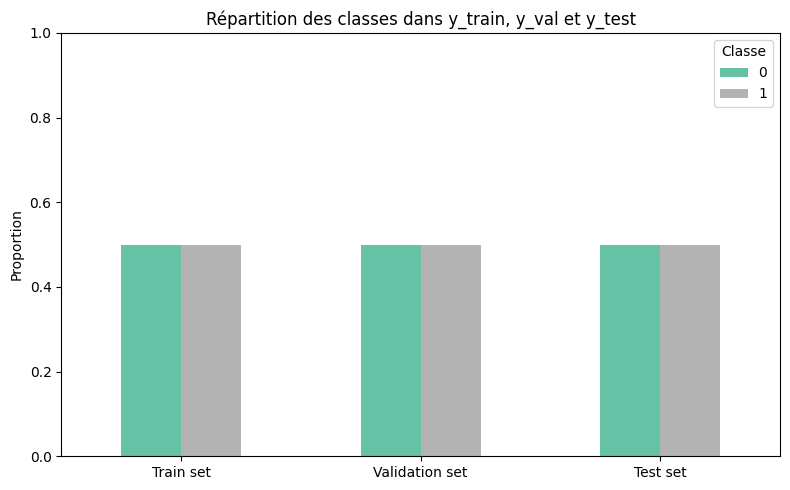

CPU times: user 1.1 s, sys: 176 ms, total: 1.28 s
Wall time: 1.28 s


In [21]:
%%time
X_train_cv, X_valid_cv, X_test_cv, y_train_cv, y_val_cv, y_test_cv = split_train_val_test(tweets_df_count_vectorizer_1gram.item(), Y, sample_size=20000)
print("Répartition dans y_train    :", pd.Series(y_train_cv).value_counts(normalize=True))
print("Répartition dans y_validation:", pd.Series(y_val_cv).value_counts(normalize=True))
print("Répartition dans y_test :", pd.Series(y_test_cv).value_counts(normalize=True))
plot_distribution(y_train_cv, y_val_cv, y_test_cv)

In [21]:
skf.get_n_splits(X_train_cv, y_train_cv)
for i, (train_index, test_index) in enumerate(skf.split(X_train_cv, y_train_cv)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[238105 238107 238108 ... 955839 955840 955841]
  Test:  index=[     0      1      2 ... 239820 239821 239823]
Fold 1:
  Train: index=[     0      1      2 ... 955839 955840 955841]
  Test:  index=[238105 238107 238108 ... 478181 478183 478185]
Fold 2:
  Train: index=[     0      1      2 ... 955839 955840 955841]
  Test:  index=[477690 477691 477692 ... 716923 716925 716926]
Fold 3:
  Train: index=[     0      1      2 ... 716923 716925 716926]
  Test:  index=[716828 716829 716830 ... 955839 955840 955841]


In [ ]:
%%time
cv_results_df = evaluate_models(X_train_cv, X_valid_cv, y_train_cv, y_val_cv, cv=skf)

  0%|          | 0/6 [00:00<?, ?it/s]

Evaluating Logistic Regression...


 17%|█▋        | 1/6 [00:32<02:42, 32.55s/it]

Evaluating Ridge Classifier...


 33%|███▎      | 2/6 [00:34<00:58, 14.52s/it]

Evaluating XGBoost...


In [ ]:
cv_results_df

## | Tf-idf

In [ ]:
X_train_tfidf, X_valid_tfidf, X_test_tfidf, y_train_tfidf, y_valid_tfidf, y_test_tfidf = split_train_val_test(tweets_df_tfidf_1gram.item(), Y, sample_size=20000)
print("Répartition dans y_train    :", pd.Series(y_train_tfidf).value_counts(normalize=True))
print("Répartition dans y_validation:", pd.Series(y_valid_tfidf).value_counts(normalize=True))
print("Répartition dans y_test :", pd.Series(y_test_tfidf).value_counts(normalize=True))
plot_distribution(y_train_tfidf, y_valid_tfidf, y_test_tfidf)

In [ ]:
%%time
tfidf_results_df = evaluate_models(X_train_tfidf, X_valid_tfidf, y_train_tfidf, y_valid_tfidf, cv=skf)

In [ ]:
tfidf_results_df

## | Word2Vec

In [ ]:
X_train_w2v, X_valid_w2v, X_test_w2v, y_train_w2v, y_valid_w2v, y_test_w2v = split_train_val_test(tweets_embeddings_word2vec, Y, sample_size=20000)
print("Répartition dans y_train    :", pd.Series(y_train_w2v).value_counts(normalize=True))
print("Répartition dans y_validation:", pd.Series(y_valid_w2v).value_counts(normalize=True))
print("Répartition dans y_test :", pd.Series(y_test_w2v).value_counts(normalize=True))
plot_distribution(y_train_w2v, y_valid_w2v,  y_test_w2v)

In [ ]:
%%time
w2v_results__df = evaluate_models(X_train_w2v, X_valid_w2v, y_train_w2v, y_valid_w2v, cv=skf)

In [ ]:
w2v_results__df

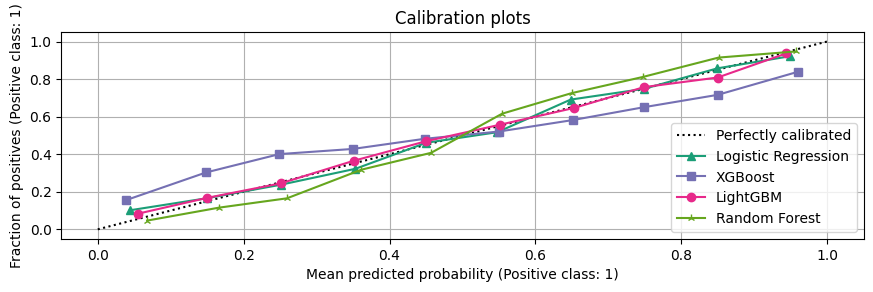

In [58]:
show_calibration_curve(models, X_test_w2v, y_test_w2v, exclude=["Ridge Classifier"])

## | FastText

In [10]:
X_train_ft, X_valid_ft, X_test_ft, y_train_ft, y_valid_ft, y_test_ft = split_train_val_test(tweets_embeddings_fasttext, Y, sample_size=20000)

In [18]:
%%time
ft_results_df = evaluate_models(X_train_ft, X_valid_ft, y_train_ft, y_valid_ft, cv=skf)

  0%|          | 0/6 [00:00<?, ?it/s]

Evaluating Logistic Regression...


 17%|█▋        | 1/6 [00:04<00:21,  4.39s/it]

8

Evaluating Ridge Classifier...


 33%|███▎      | 2/6 [00:04<00:08,  2.15s/it]

8

Evaluating XGBoost...


 50%|█████     | 3/6 [00:50<01:05, 21.95s/it]

8

Evaluating LightGBM...


 83%|████████▎ | 5/6 [01:12<00:14, 14.10s/it]

8

Evaluating Naive Bayes...
8

Evaluating Random Forest...


100%|██████████| 6/6 [02:29<00:00, 24.91s/it]

8

CPU times: user 3min 25s, sys: 2.27 s, total: 3min 27s
Wall time: 2min 29s


In [19]:
display(ft_results_df)

,Model,train_mean_score,test_score,test_precision,test_recall,test_f1,test_auc,test_mse,train_time (s)
0,Logistic Regression,0.719833,0.72125,0.719603,0.7250,0.722291,0.72125,0.27875,4.388742
1,Ridge Classifier,0.714500,0.72100,0.721000,0.7210,0.721000,0.72100,0.27900,0.586775
2,XGBoost,0.696167,0.69600,0.695414,0.6975,0.696455,0.69600,0.30400,45.497723
3,LightGBM,0.701167,0.69525,0.697521,0.6895,0.693488,0.69525,0.30475,21.925759
4,Naive Bayes,0.643000,0.63750,0.632850,0.6550,0.643735,0.63750,0.36250,0.188107
5,Random Forest,0.685333,0.68325,0.696726,0.6490,0.672017,0.68325,0.31675,76.890152


# Approche 2: Modèle sur mesure avancé (Reseau de Neurone)